## Notebook for running thompson sampling and for visualization of results

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import matplotlib.ticker as ticker

sys.path.append('..')

In [3]:
from thompson_sampler.thompson_sampler import ThompsonSampler

In [4]:
np.random.seed(9999)

### Define hyperparameters and run thompson sampling for a bernoulli bandit

In [5]:
num_steps = 10000
thetas=[0.1, 0.4, 0.45, 0.6, 0.61]
num_arms = len(thetas)


In [6]:
ts_sampler = ThompsonSampler(num_arms, thetas=thetas)

In [7]:
ts_sampler.run(num_steps)

In [8]:
posteriors_over_time = ts_sampler.get_posteriors_over_time

### Plot posterior distributions over time

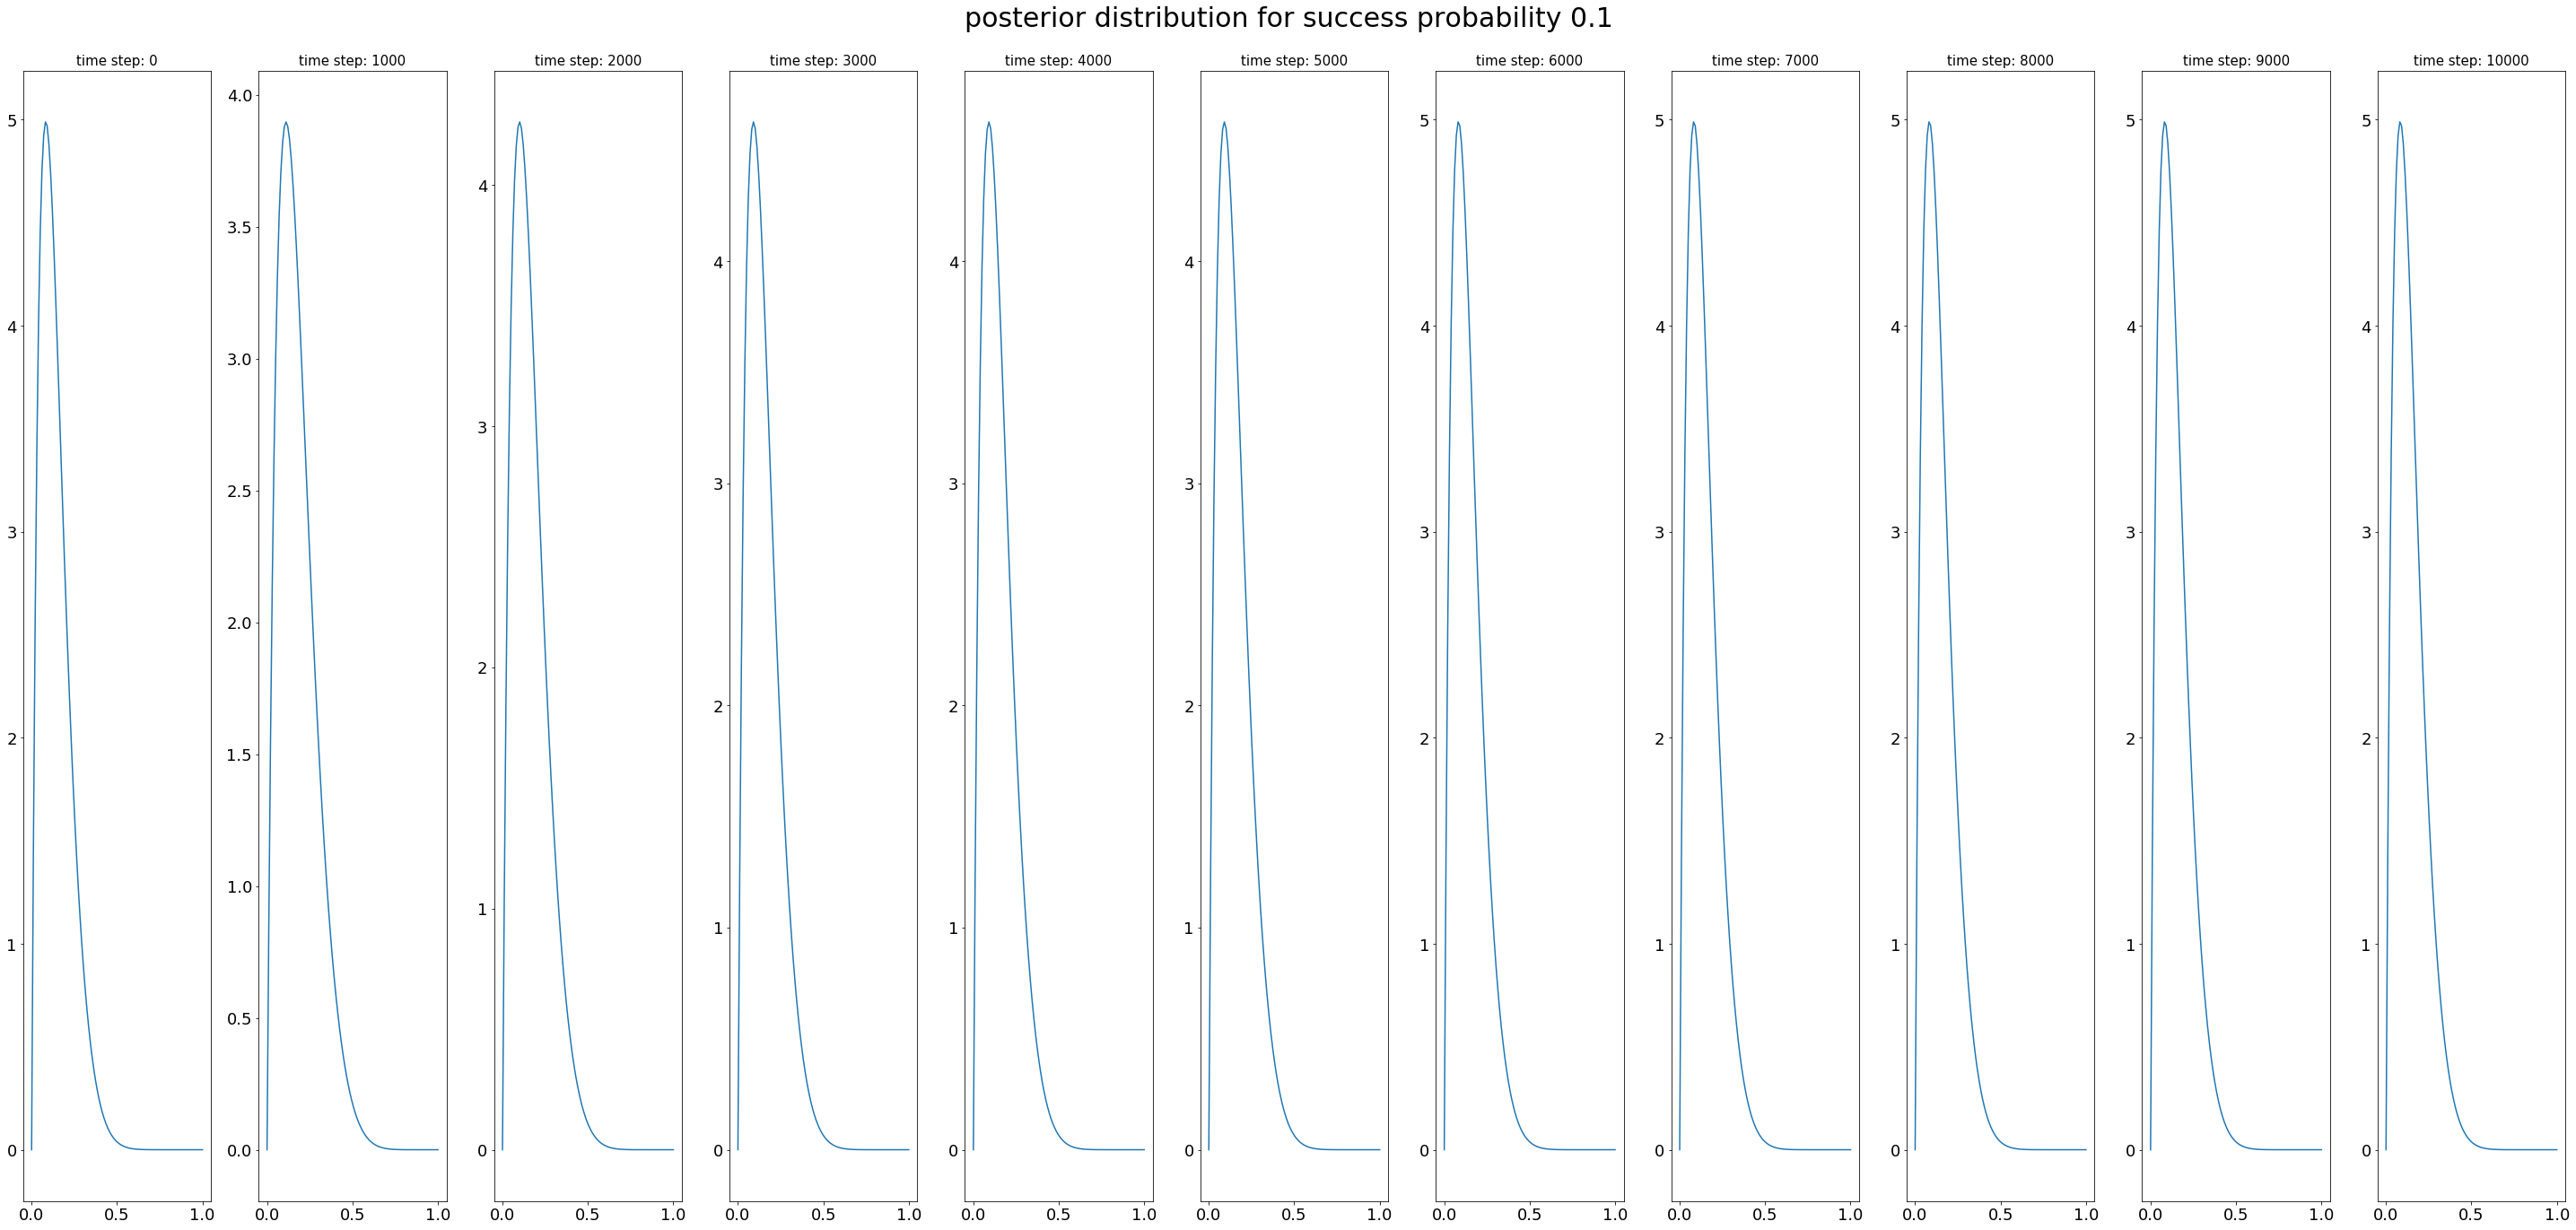

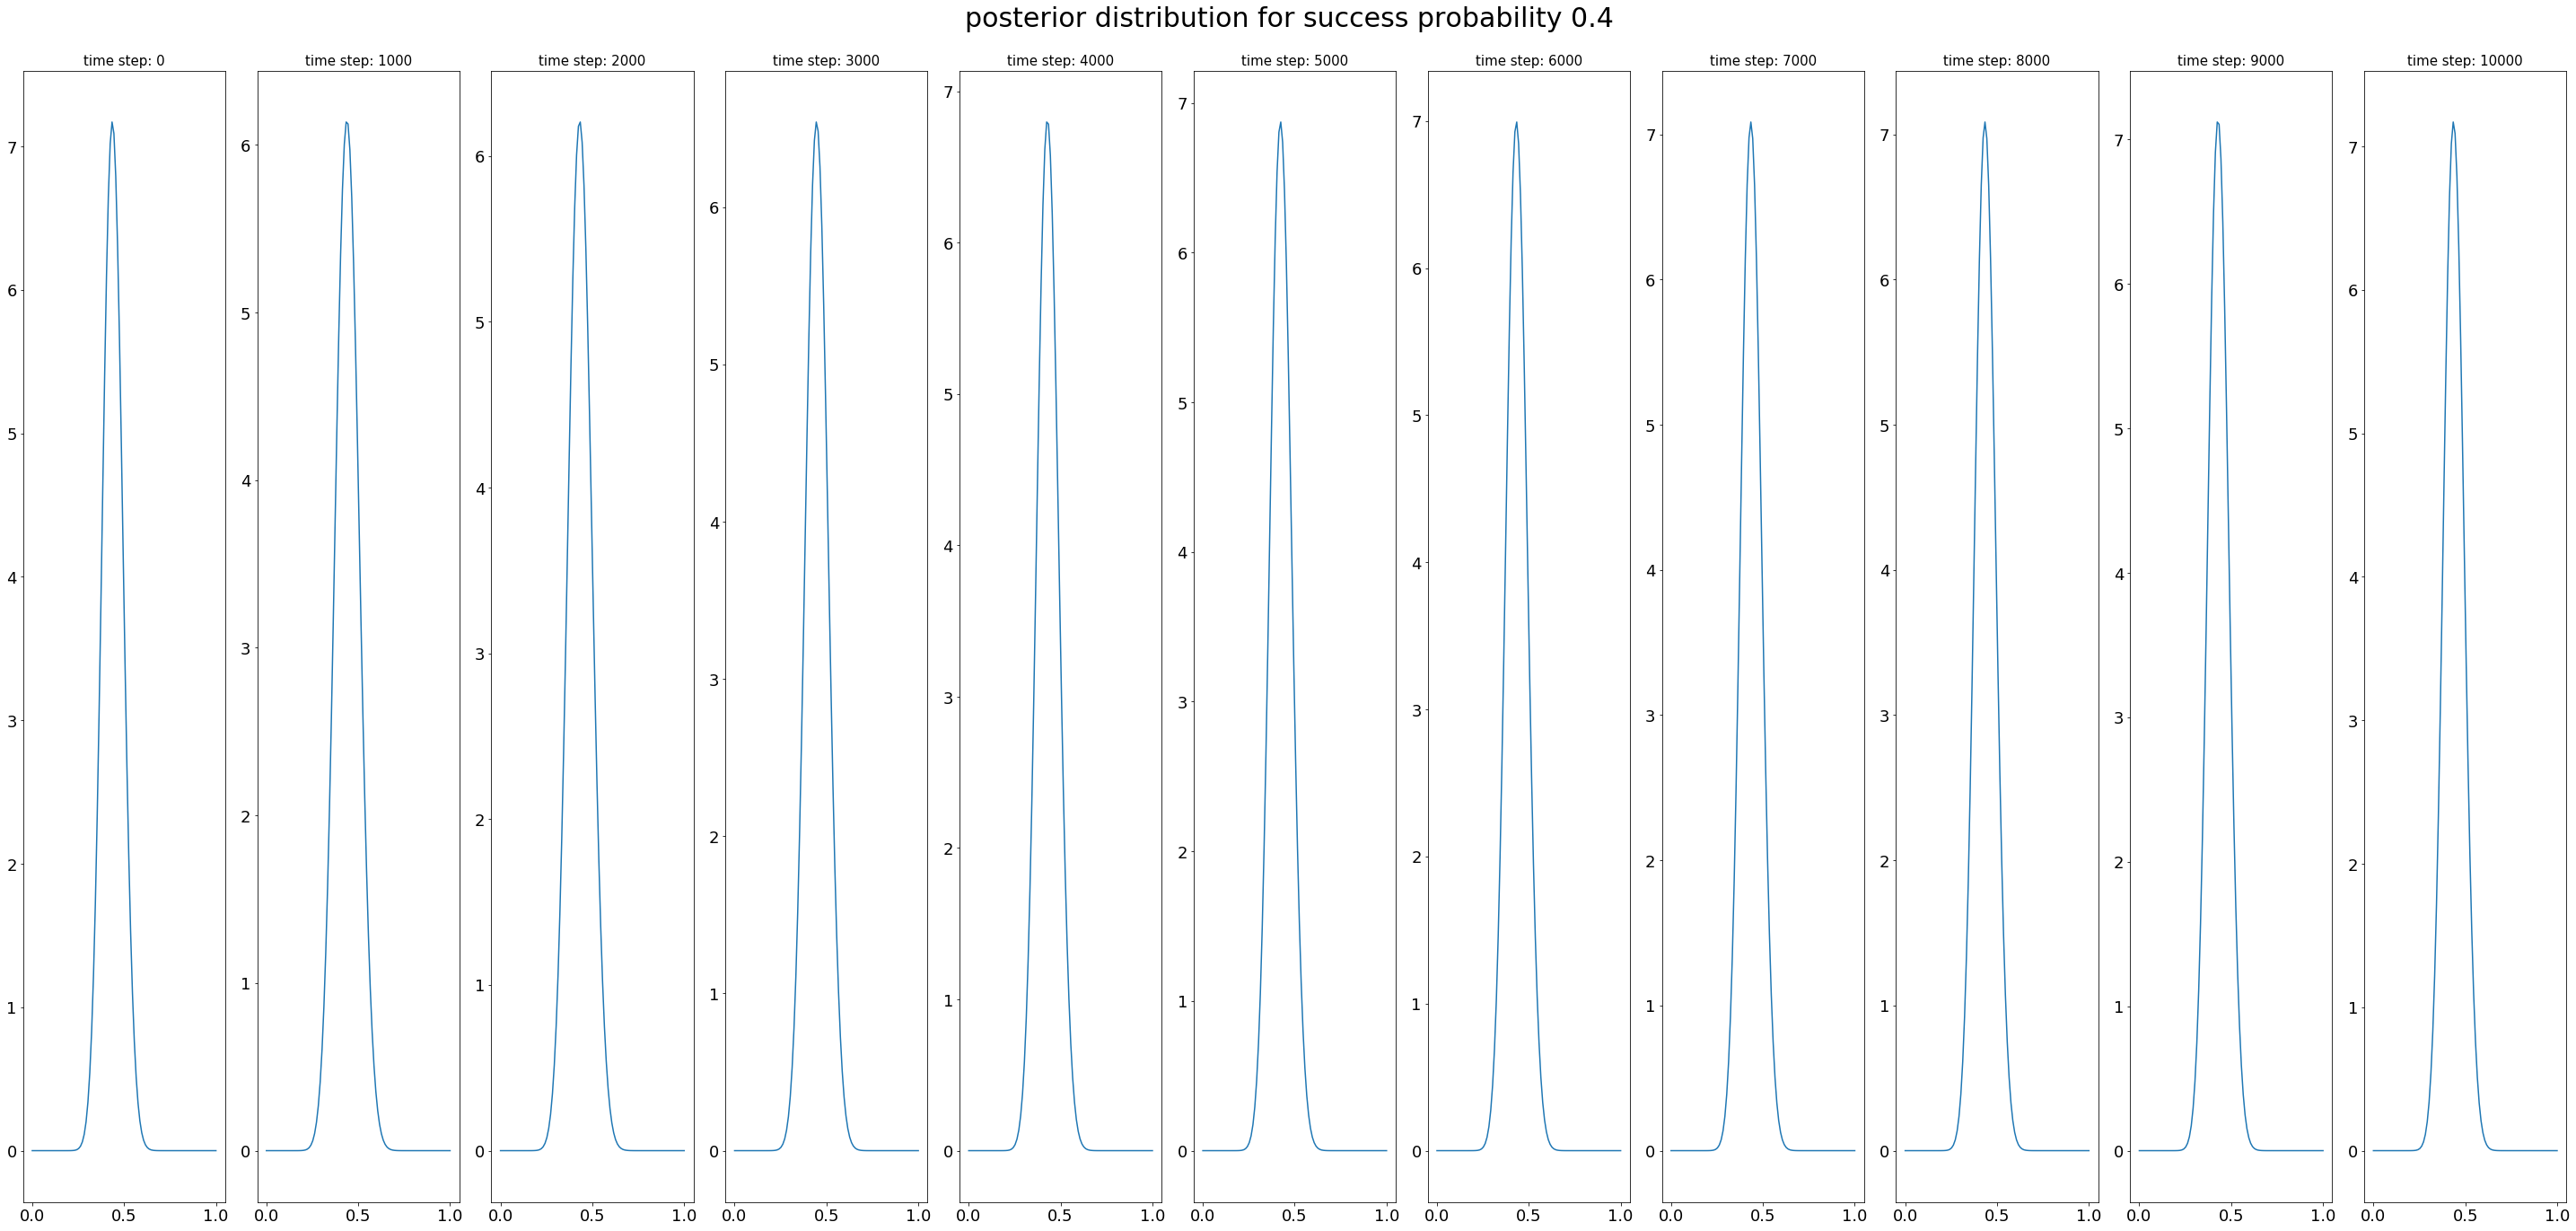

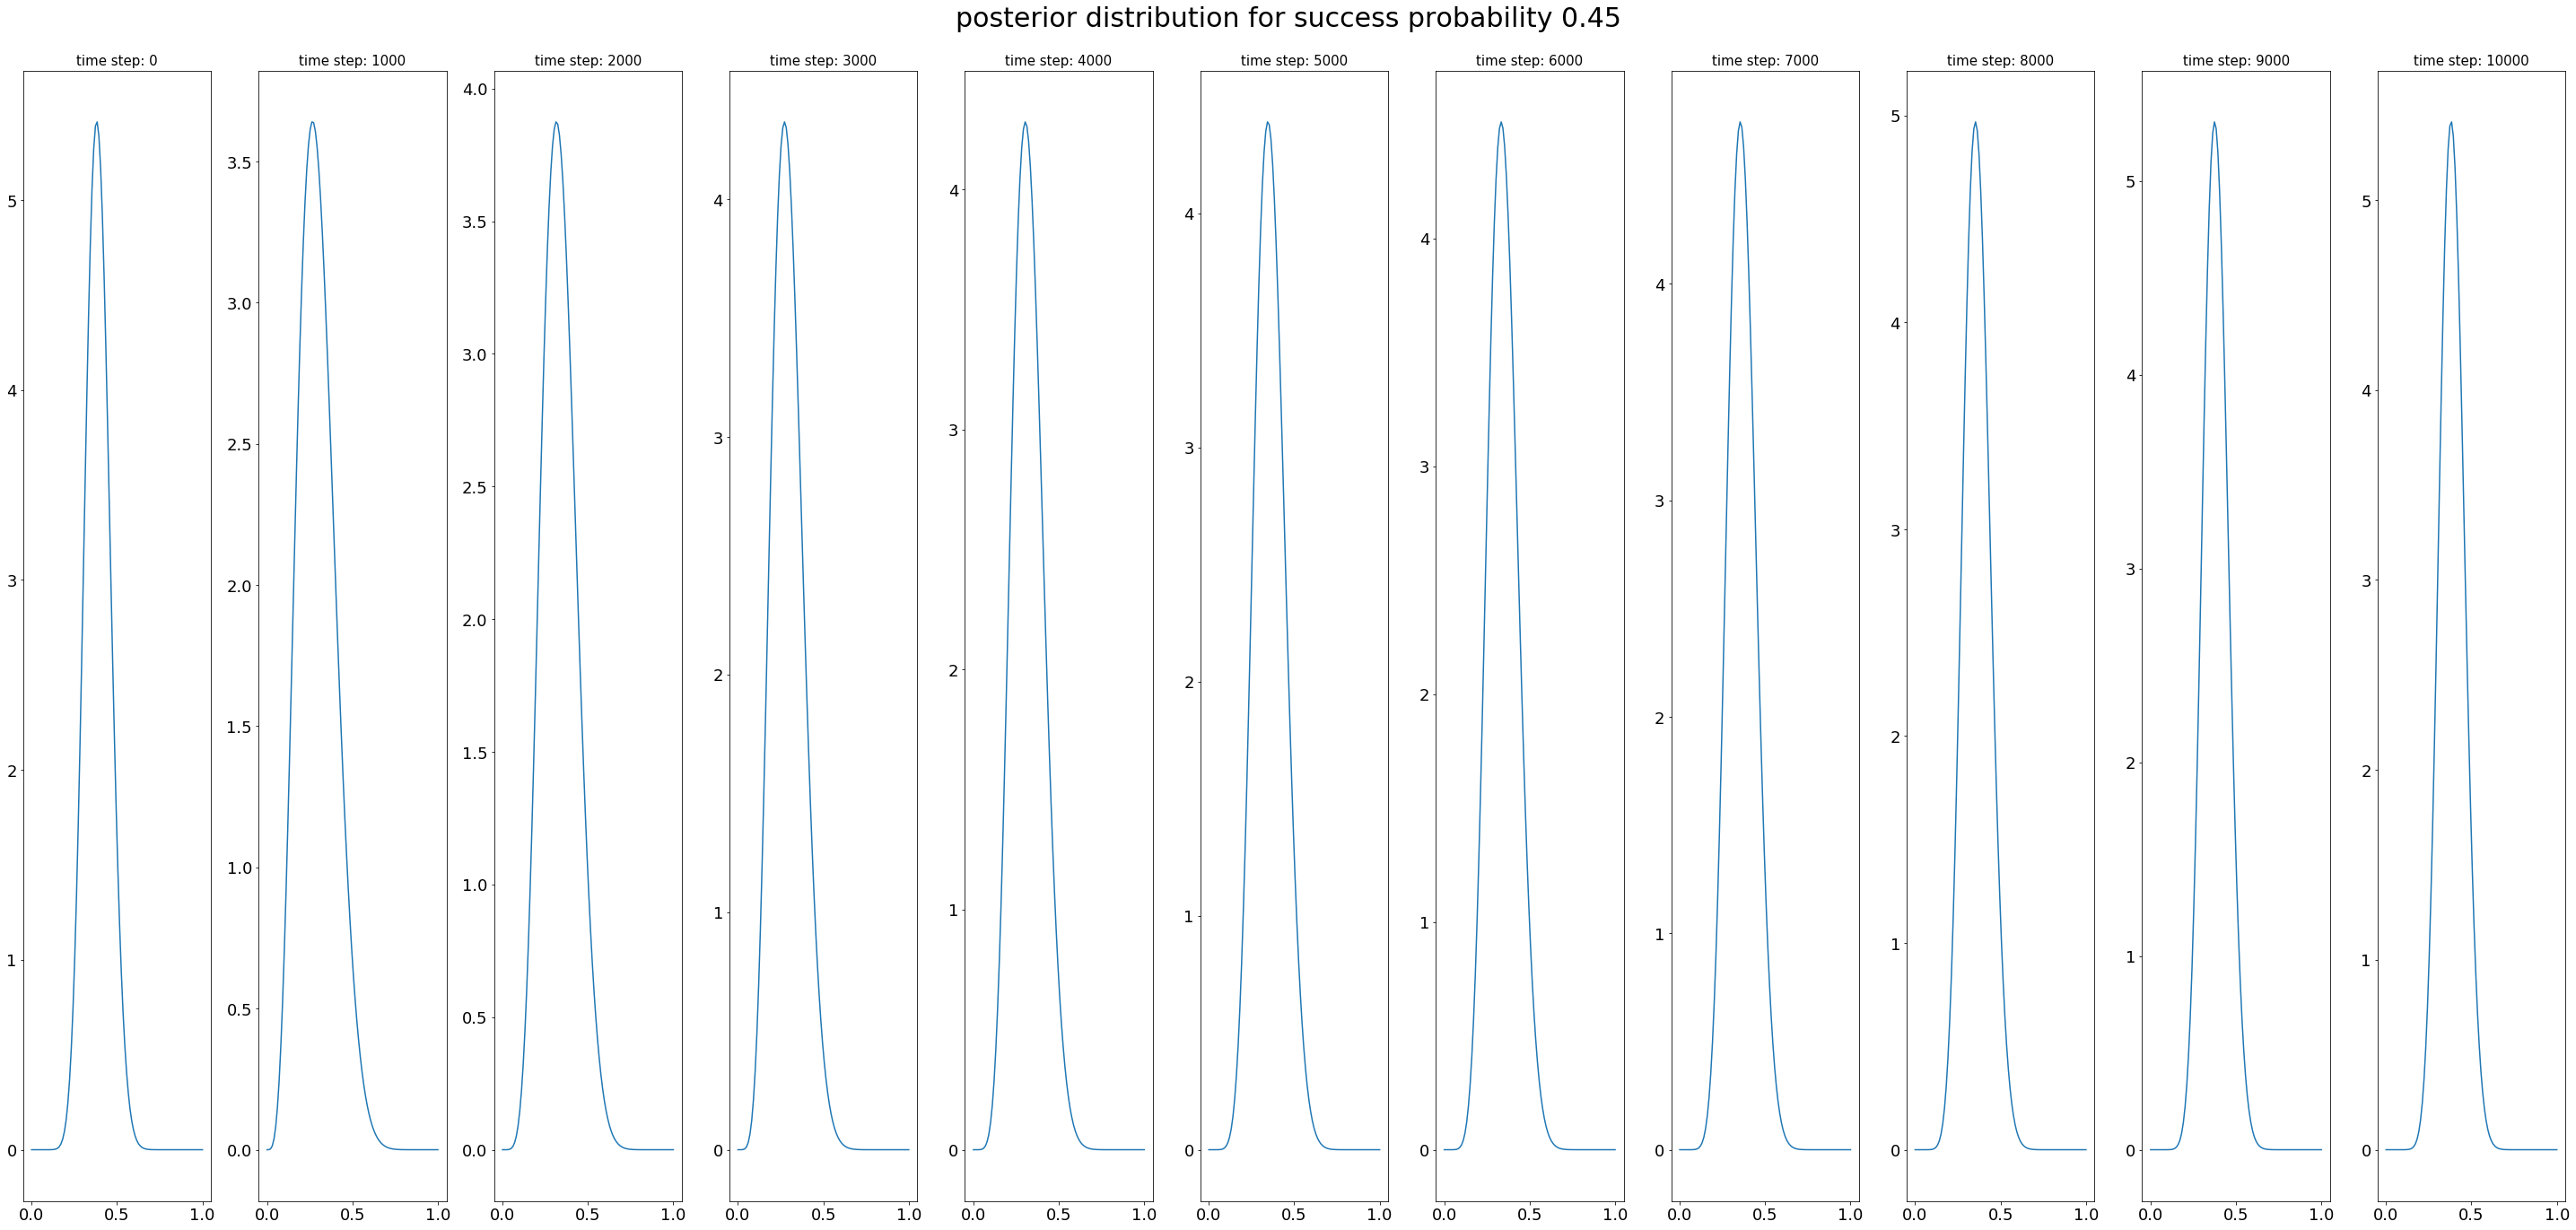

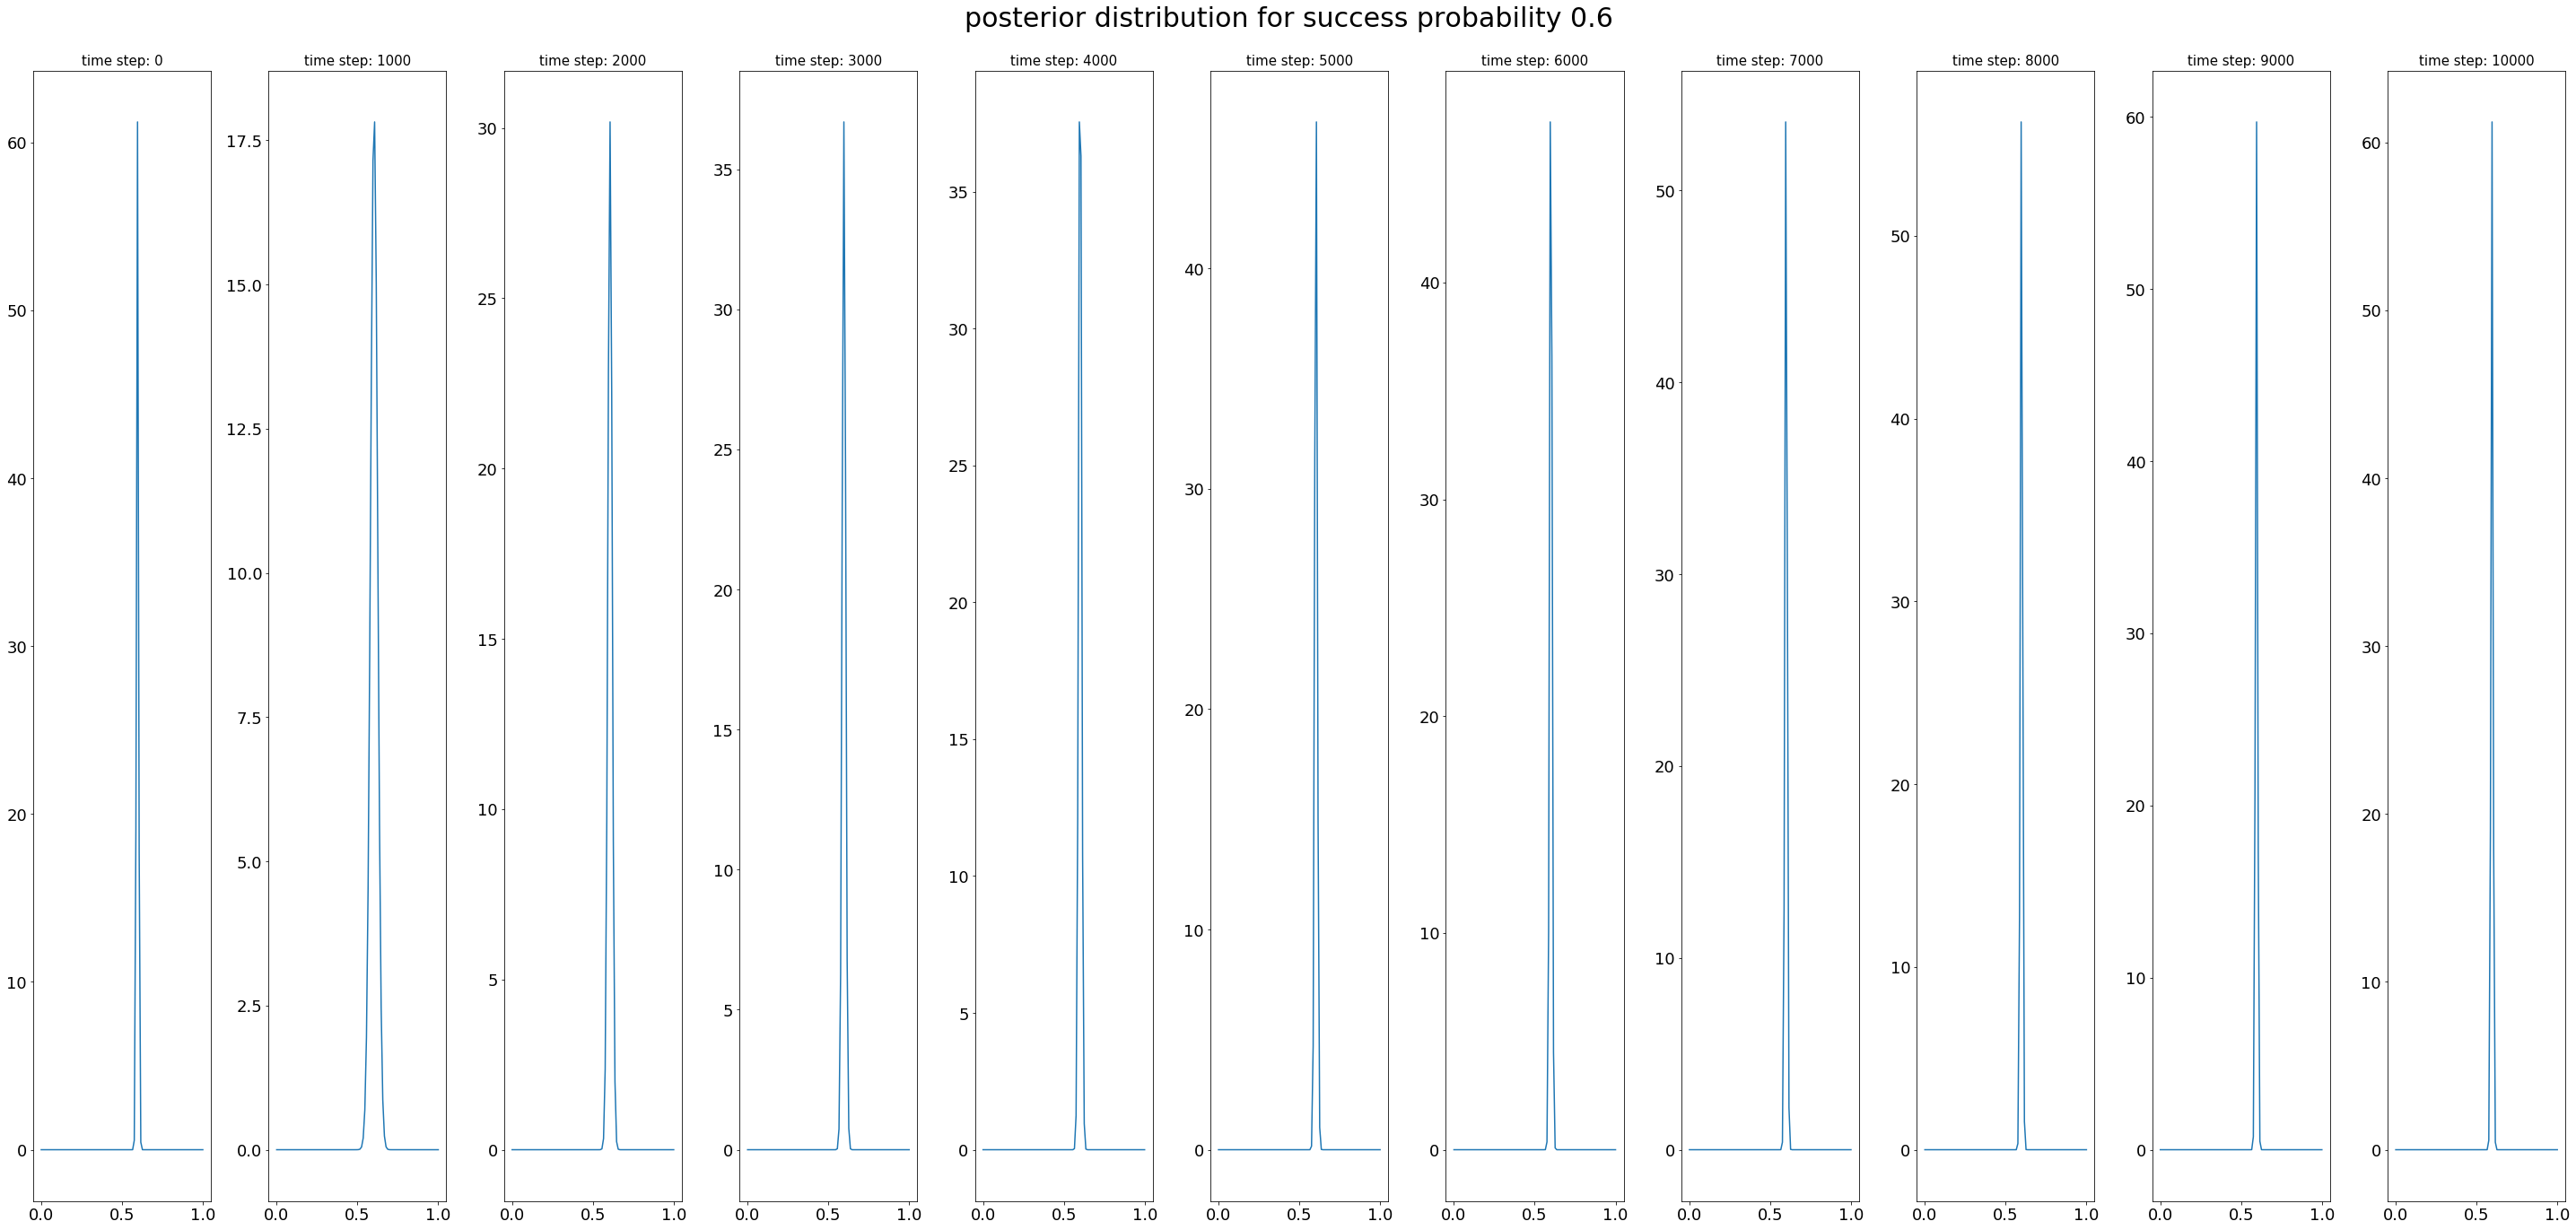

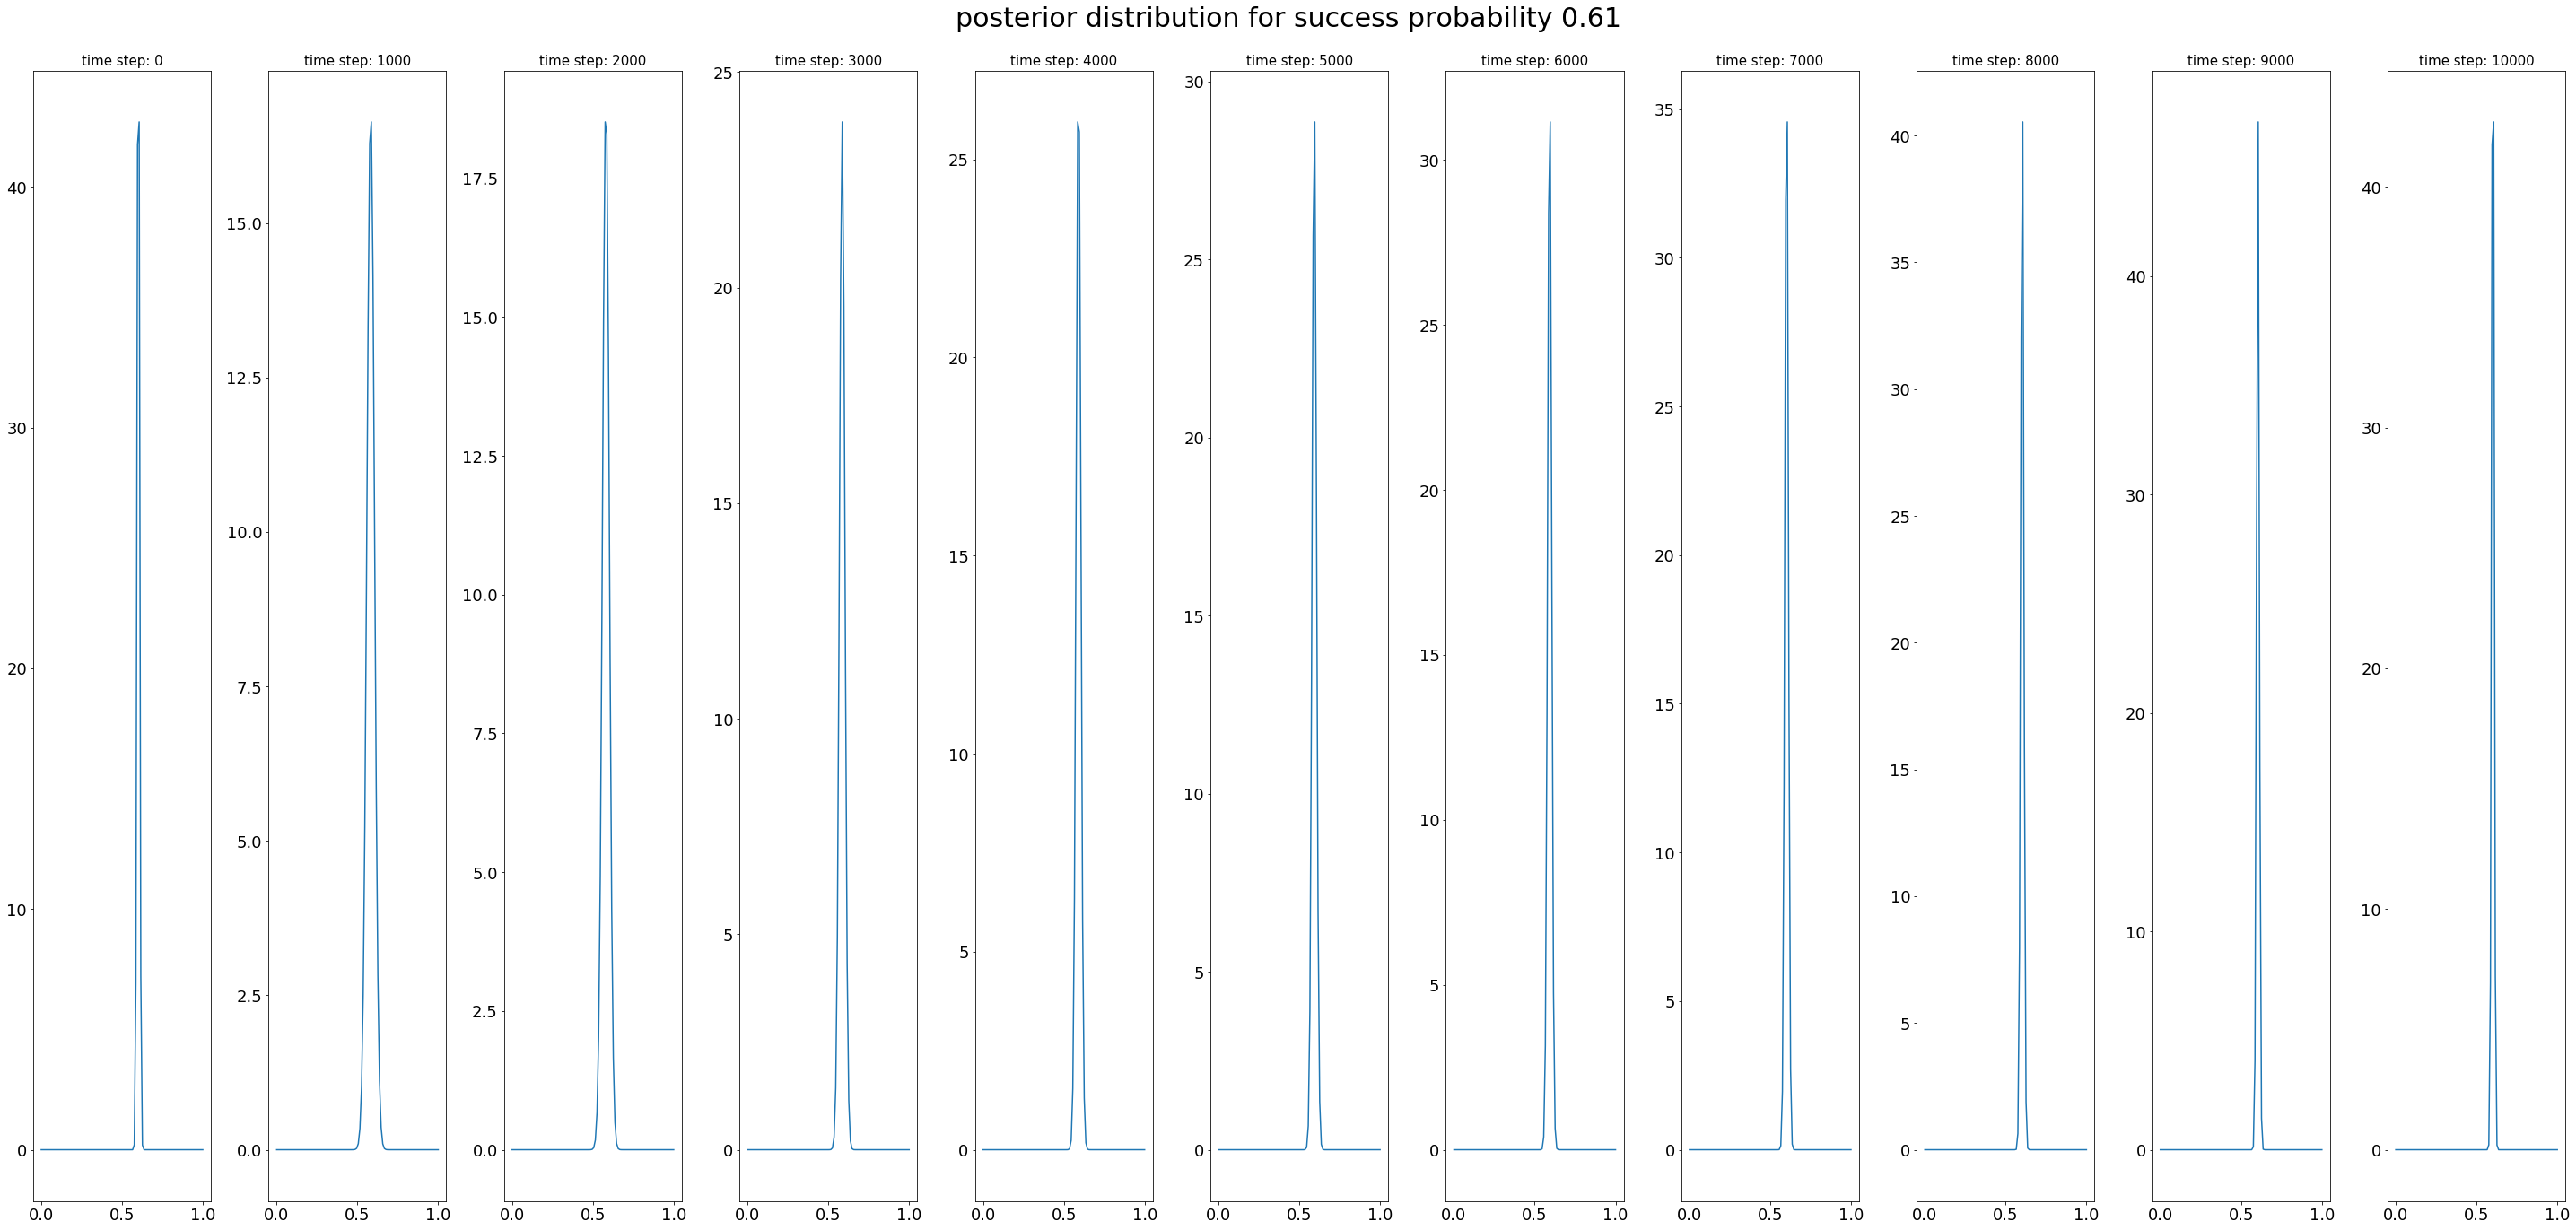

In [9]:
x = np.linspace(0,1,100)
waiting_time = 1000
plots_per_row = int(math.ceil(len(posteriors_over_time)/waiting_time))

for i in range(num_arms):
    params_arm = []
    for time_step, params in enumerate(posteriors_over_time):
        if time_step % waiting_time == 0:
            params_arm_time_step = params.get(i)
            params_arm_time_step['time_step'] = time_step
            params_arm.append(params_arm_time_step)
    
    f, ax = plt.subplots(1, plots_per_row, figsize=(40,20))
    for idx, params in enumerate(params_arm):
        y = ss.beta.pdf(x, params['alpha'], params['beta'])
        ax[idx].plot(x,y)
        ax[idx].tick_params(axis='both', which='major', labelsize=18)  
        ax[idx].set_title(f"time step: {params['time_step']}", fontsize=15)
#         ax[idx].tick_params(axis='both', which='minor', labelsize=15)    
 

    title = plt.suptitle(f"posterior distribution for success probability {thetas[i]}", fontsize=30) 
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.9)
    

### Plot regrets over time 

Text(0.5, 1.0, 'Regrets over time')

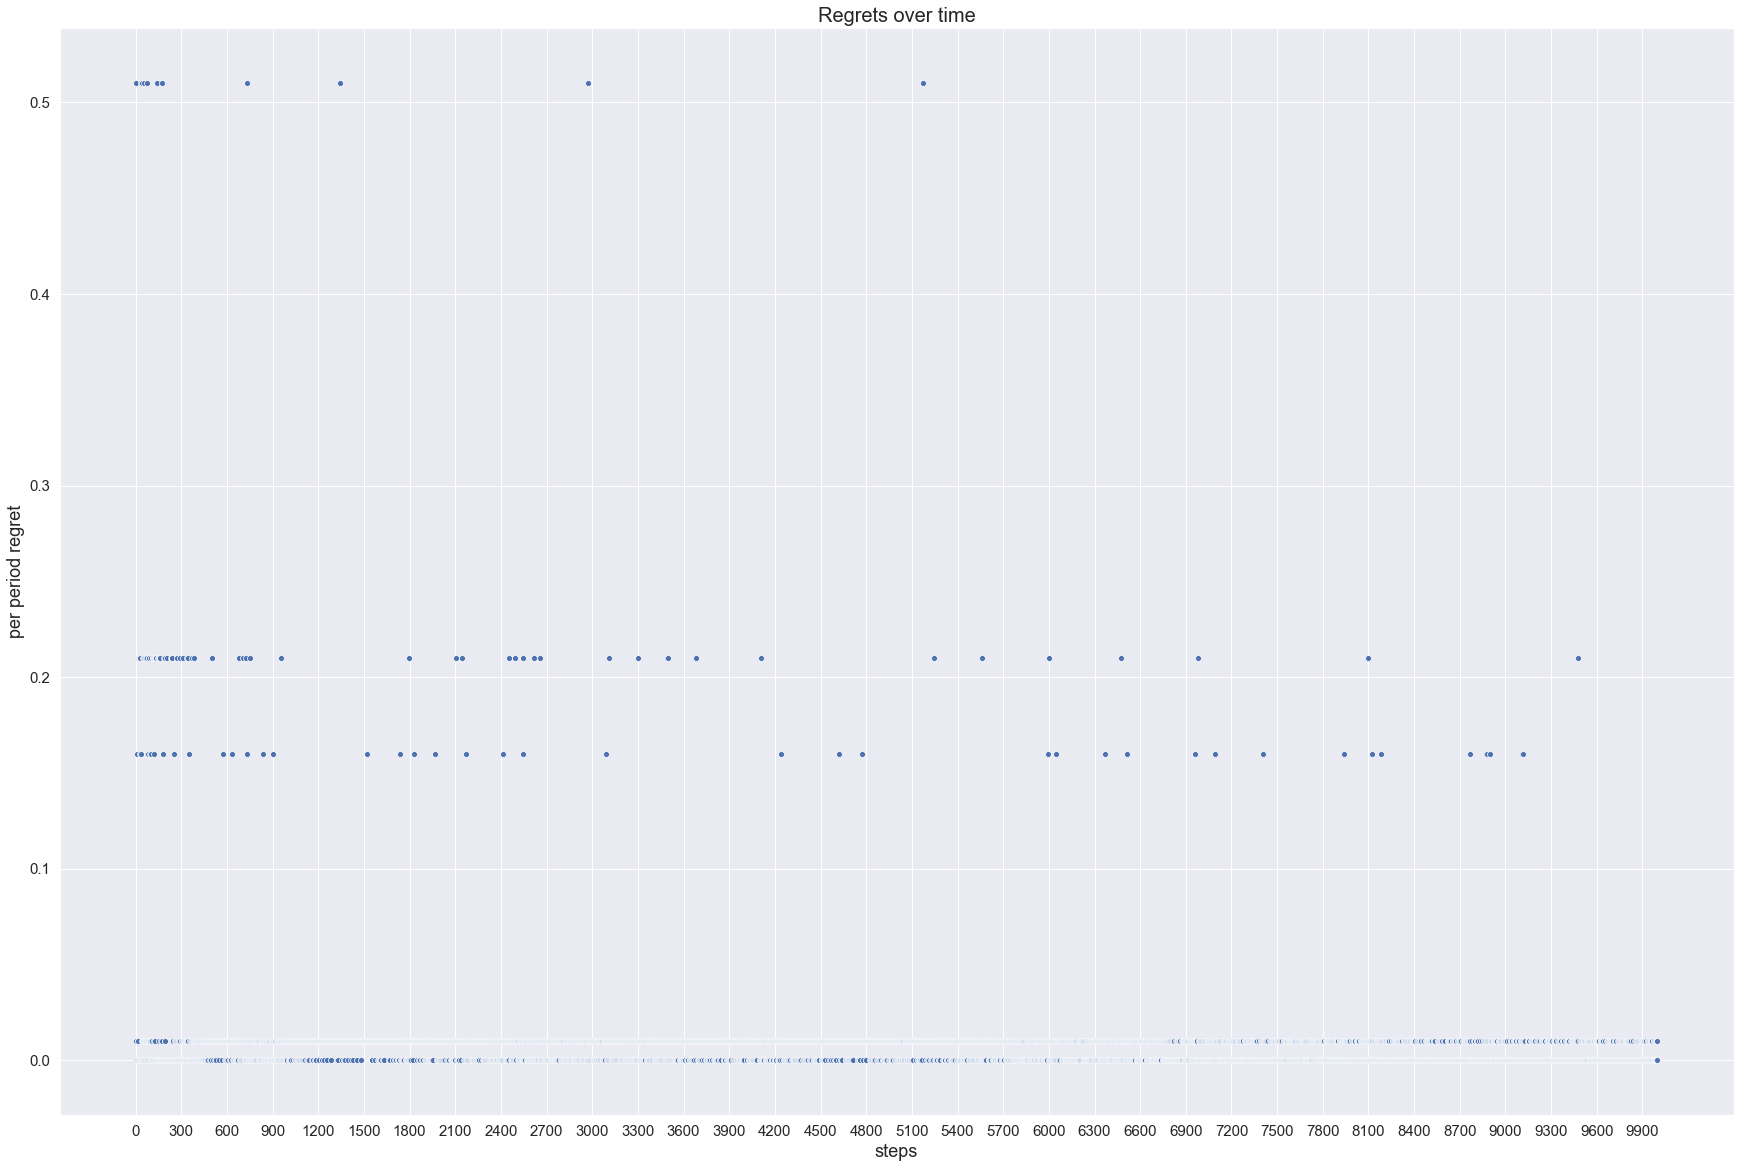

In [10]:
regrets = ts_sampler.get_regrets
sns.set(rc={'figure.figsize':(30,20)})
ax = sns.scatterplot(x=range(len(regrets)), y=regrets)
ax.set_xlabel('steps', fontsize=18)
ax.set_ylabel('per period regret', fontsize=18)
ax.xaxis.set_ticks(np.arange(0, num_steps+3, 300))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(axis='both', which='major', labelsize=15)  
ax.set_title("Regrets over time", fontsize=20)

In [11]:
# show how often different regrets occur over the whole time
Counter(regrets)

Counter({0.010000000000000009: 5671,
         0.0: 4197,
         0.51: 12,
         0.15999999999999998: 42,
         0.20999999999999996: 78})

Most often the positive regret stems from the fact that the arm with success probablity of 0.6 was selected instead of the one with the hightest success probaility of 0.61. The highest regret per time step occurs only at the beginning because the arm with the lowest success probability is not chosen in later time steps

In [12]:
def calculate_arm_means(posteriors_time: list, arm_idx: int) -> list:
    means_over_time = []
    for posteriors in posteriors_time:
        alpha = posteriors[arm_idx]['alpha']
        beta = posteriors[arm_idx]['beta']
        mean = alpha/(alpha+beta)
        means_over_time.append(mean)
    return means_over_time    

### Plot posteriors over time 

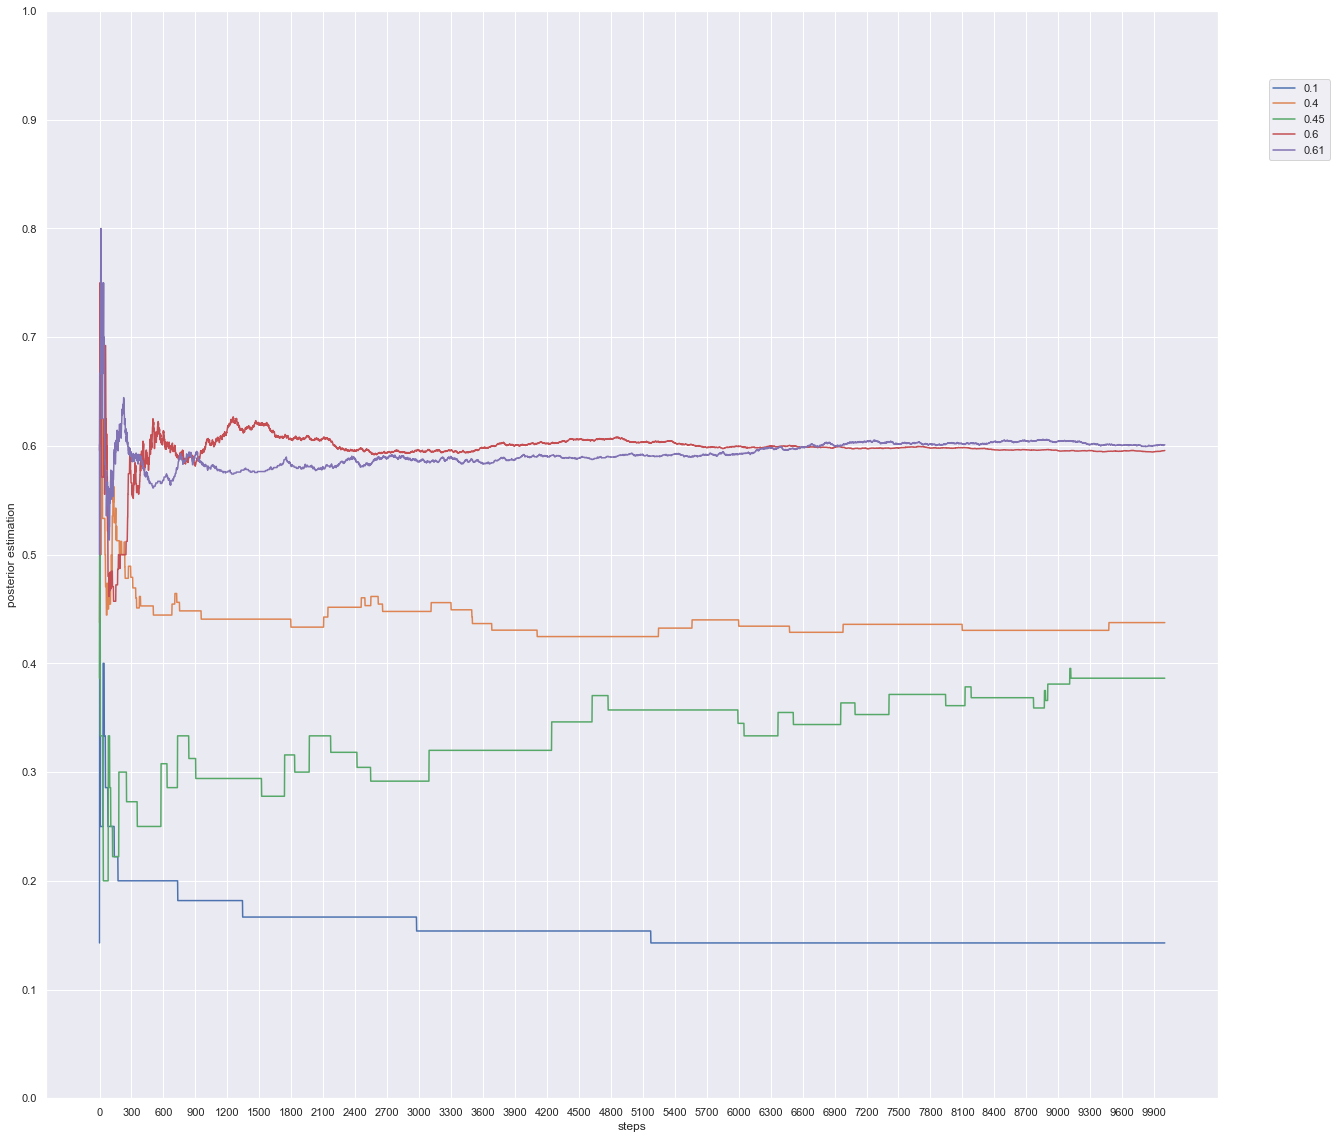

In [13]:
sns.set(rc={'figure.figsize':(30,20)})

means_over_time = {}
for arm_idx in range(num_arms):
     means_over_time[arm_idx] = calculate_arm_means(posteriors_over_time, arm_idx)
    

for i in range(num_arms):
      ax = sns.lineplot(x=range(len(means_over_time[i])), y=means_over_time[i], legend='full')

# Shrink current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

# Put a legend to the right of the current axis
ax.legend(ts_sampler.get_thetas, loc='center right', bbox_to_anchor=(1.1, 0.9))

ax.set_xlabel('steps')
ax.set_ylabel('posterior estimation')
ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.xaxis.set_ticks(np.arange(0, num_steps+3, 300))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))



In [14]:
for arm_idx in range(num_arms):
     print(means_over_time[arm_idx][-1])

0.14285714285714285
0.4375
0.38636363636363635
0.5958046888771373
0.6010954989283163


When running Thompson-Sampling long enough the true probabilities are estimated in the correct order.
Greatest difference between posteriors and true probabilities for the arm with the smallest success probability, (e.g. 0.1) because this arm is less often selected for sampling.  
For estimating all accuracies better the algorithm should focus more on exploring than on exploiting. Instead of sampling from the beta distribution, we could sample from the uniform distribution (which corresponds to setting all alphas and betas to 1 for the beta distribution).
